In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud,STOPWORDS

In [2]:
data_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
data_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [3]:
data_train.shape

(7613, 5)

In [4]:
data_train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
# Check the nulls
data_train.isna().sum(axis=0)

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
del data_train['keyword']
del data_train['location']
data_train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


# Exploratory Data Analysis (EDA)

target_values --- 
 0    4342
1    3271
Name: target, dtype: int64
********************************************************************************


Text(0, 0.5, 'Sentiment Count')

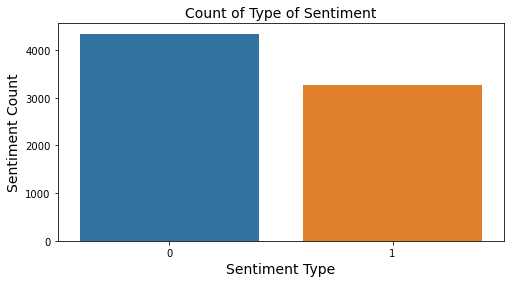

In [8]:
target_values = data_train['target'].value_counts() #index then values
print('target_values --- \n', target_values)
print('**'*40)

## Plotting
plt.figure(figsize=(8,4))
sns.countplot(x='target', data=data_train,
              order=target_values.index)
plt.title('Count of Type of Sentiment', fontsize=14, c='k')
plt.xlabel('Sentiment Type', fontsize=14, c='k')
plt.ylabel('Sentiment Count', fontsize=14, c='k')

# Wordcloud for positive reasons

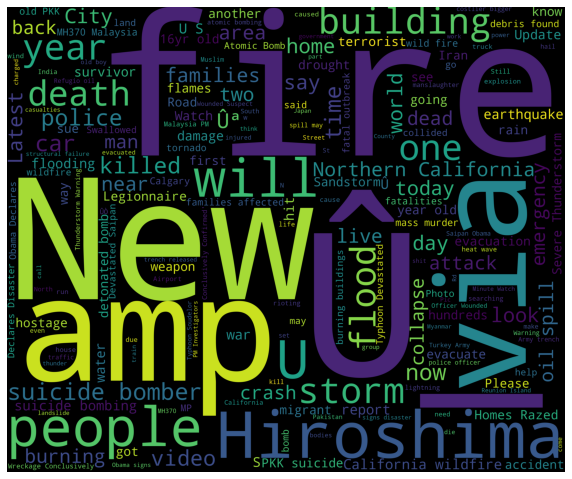

In [9]:
new_df=data_train[data_train['target']==1]
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Wordcloud for Negative sentiments of tweets

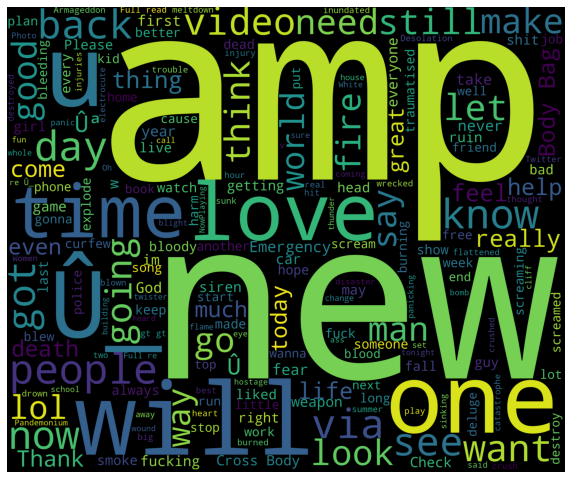

In [10]:
new_df=data_train[data_train['target']==0]
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Preprocessing the data

In [11]:
data_train['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [12]:
def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))

In [13]:
data_train['clean_tweet']=data_train['text'].apply(lambda x: tweet_to_words(x))
data_train['clean_tweet']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    aria ahrary thetawniest control wild fires cal...
7610             utc km volcano hawaii http co zdtoyd ebj
7611    police investigating e bike collided car littl...
7612    latest homes razed northern california wildfir...
Name: clean_tweet, Length: 7613, dtype: object

In [14]:
data_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
data_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [15]:
data_test['clean_tweet']=data_test['text'].apply(lambda x: tweet_to_words(x))
data_test['clean_tweet']

0                             happened terrible car crash
1       heard earthquake different cities stay safe ev...
2       forest fire spot pond geese fleeing across str...
3                   apocalypse lighting spokane wildfires
4                     typhoon soudelor kills china taiwan
                              ...                        
3258    earthquake safety los angeles safety fasteners...
3259    storm ri worse last hurricane city amp others ...
3260     green line derailment chicago http co utbxlcbiuy
3261    meg issues hazardous weather outlook hwo http ...
3262    cityofcalgary activated municipal emergency pl...
Name: clean_tweet, Length: 3263, dtype: object

In [16]:
pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 3.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 8.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
#Removing Contractions
import contractions
for row in data_train['clean_tweet']:
    contractions.fix(row)

In [18]:
#Removing Contractions
import contractions
for row in data_test['clean_tweet']:
    contractions.fix(row)

# preparing the data for LSTM

In [19]:
#train
#number of row
lenght_text =len(data_train['clean_tweet'])
max_words = len(set(" ".join(data_train['clean_tweet']).split()))
lenght_text,max_words

(7613, 21980)

In [20]:
#by turning each text into either a sequence of integers 
#(each integer being the index of a token in a dictionary) 
#dictionary make by words which is the most frequency is put first and take 0 ...
max_fatures = max_words
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data_train['clean_tweet'].values)
X = tokenizer.texts_to_sequences(data_train['clean_tweet'].values)
X = pad_sequences(X)
X

array([[    0,     0,     0, ...,  1468,  4602,    24],
       [    0,     0,     0, ...,  6872,  6873,  1070],
       [    0,     0,     0, ...,   570,  1258,   959],
       ...,
       [    0,     0,     0, ...,     1,  6838,  6839],
       [    0,     0,     0, ...,    70,  1915,   231],
       [    0,     0,     0, ...,     2,     1, 21979]], dtype=int32)

In [21]:
data_test.isna().sum(axis=0)

id                0
keyword          26
location       1105
text              0
clean_tweet       0
dtype: int64

In [22]:
#test
#number of row
lenght_text =len(data_test['clean_tweet'])
max_words = len(set(" ".join(data_test['clean_tweet']).split()))
print(lenght_text,max_words)
max_fatures = max_words
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data_test['clean_tweet'].values)
x_test = tokenizer.texts_to_sequences(data_test['clean_tweet'].values)
x_test = pad_sequences(x_test)
x_test

3263 12493


array([[    0,     0,     0, ...,   862,    69,    37],
       [    0,     0,     0, ...,   625,   768,   342],
       [    0,     0,     0, ...,   425,  1147,   343],
       ...,
       [    0,     0,     0, ...,     2,     1, 12492],
       [    0,     0,     0, ...,     2,     1,    25],
       [    0,     0,     0, ...,    16,   182,  2338]], dtype=int32)

In [23]:
x_test.shape

(3263, 27)

In [24]:
X.shape

(7613, 27)

In [25]:
Y = pd.get_dummies(data_train['target']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6471, 27) (6471, 2)
(1142, 27) (1142, 2)


# lstm

In [26]:
embed_dim = 128
lstm_out = 200

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

2023-01-25 12:43:45.561365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 12:43:45.562777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 12:43:45.720097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 12:43:45.721406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 12:43:45.722519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 27, 128)           1599104   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               263200    
_________________________________________________________________
dense (Dense)                (None, 2)                 402       
Total params: 1,862,706
Trainable params: 1,862,706
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)
batch_size = 32
history=model.fit(X_train, Y_train, epochs = 20, batch_size=batch_size
          ,validation_data=(X_test, Y_test), 
          verbose = 2,callbacks=[early_stop])

2023-01-25 12:43:49.912389: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-01-25 12:43:53.170240: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


203/203 - 7s - loss: 0.5202 - accuracy: 0.7402 - val_loss: 0.4670 - val_accuracy: 0.7960
Epoch 2/20
203/203 - 1s - loss: 0.2932 - accuracy: 0.8795 - val_loss: 0.5412 - val_accuracy: 0.7732
Epoch 3/20
203/203 - 1s - loss: 0.1788 - accuracy: 0.9320 - val_loss: 0.6153 - val_accuracy: 0.7522


In [28]:
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
Y_test=np.argmax(Y_test, axis=1)
accuracy_score(Y_test,y_pred)

0.7521891418563923

In [29]:
cm = confusion_matrix(Y_test, y_pred)
cm

array([[509, 142],
       [141, 350]])

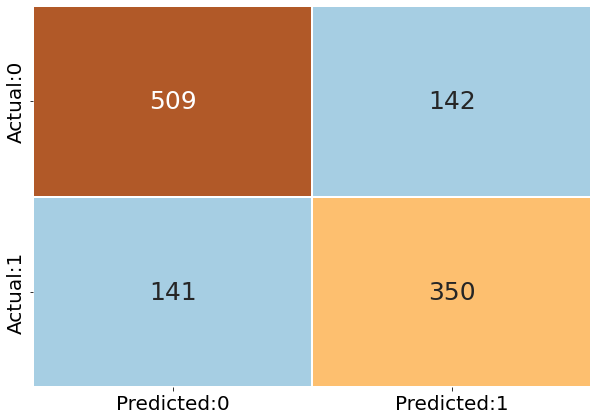

In [30]:
#defining the size of the canvas
plt.rcParams['figure.figsize'] = [10,7]
#confusion matrix to DataFrame
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1',], index = ['Actual:0','Actual:1',])
#plotting the confusion matrix
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Paired', cbar = False,linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [31]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       651
           1       0.71      0.71      0.71       491

    accuracy                           0.75      1142
   macro avg       0.75      0.75      0.75      1142
weighted avg       0.75      0.75      0.75      1142



# submission

In [32]:
data_test

,id,keyword,location,text,clean_tweet
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles safety fasteners...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm ri worse last hurricane city amp others ...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,green line derailment chicago http co utbxlcbiuy
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issues hazardous weather outlook hwo http ...


In [33]:
x_test.shape

(3263, 27)

In [34]:
y_pre=model.predict(x_test)
y_pre_=[]
for x in y_pre:
    y_pre_.append(np.argmax(x))
    #print(x)
y_pre_=np.array(y_pre_)

In [35]:
id=np.array(data_test['id'])

In [36]:
sub= pd.DataFrame({'id': id, 'target': y_pre_}, columns=['id', 'target'])

In [37]:
sub

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,1
3261,10874,1


In [38]:
sub.to_csv('submission.csv',index=False)

In [39]:
sub.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,0


# preparing data to use SVM

In [40]:
x = data_train.clean_tweet
y = data_train.target
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=.15, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

6471 6471
1142 1142


In [41]:
#vector words or word embadding
from sklearn.feature_extraction.text import CountVectorizer
# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [42]:
#training SVM model with linear kernel
#Support Vector Classification-wrapper around SVM
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state = 10)
model.fit(x_train_dtm, y_train)

SVC(kernel='linear', random_state=10)

In [43]:
#predicting output for test data
pred = model.predict(x_test_dtm)
#accuracy score
accuracy_score(y_test,pred)

0.7653239929947461

In [44]:
cm = confusion_matrix(y_test, pred)
cm

array([[547, 104],
       [164, 327]])